In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
df_obs_cohort_lee = pd.read_csv('../data/lee_obs_cohort.csv')
df_pred_cohort_lee = pd.read_csv('../data/lee_forecasts_cohort.csv')
df_obs_cohort_dl = pd.read_csv('../data/dl_obs_cohort.csv')
df_pred_cohort_dl = pd.read_csv('../data/dl_forecasts_cohort.csv')
df_pred_cohort_fr = pd.read_csv('../data/freeze_forecasts_cohort.csv')
df_obs_cohort_fr = pd.read_csv('../data/freeze_obs_cohort.csv')

In [27]:
print(df_pred_cohort_dl.shape)
print(df_pred_cohort_lee.shape)

(477210, 7)
(476280, 7)


In [35]:
# Compare dl_obs_cohort.csv and lee_obs_cohort.csv
print(f"DL obs shape:  {df_obs_cohort_dl.shape}")
print(f"Lee obs shape: {df_obs_cohort_lee.shape}")
print(f"DL columns:  {list(df_obs_cohort_dl.columns)}")
print(f"Lee columns: {list(df_obs_cohort_lee.columns)}")

# Find common merge keys
merge_cols = ['Age', 'Year', 'Country', 'JumpOffYear']

# Merge to find matching and non-matching rows
comparison = df_obs_cohort_dl.merge(
    df_obs_cohort_lee, on=merge_cols, suffixes=('_dl', '_lee'), how='outer', indicator=True
)

print(f"\n--- Merge results ---")
print(comparison['_merge'].value_counts())

# Rows only in DL
only_dl = comparison[comparison['_merge'] == 'left_only']
print(f"\nRows only in DL obs: {len(only_dl)}")
if len(only_dl) > 0:
    print("Sample rows only in DL:")
    print(only_dl[merge_cols].drop_duplicates().head(20))
    print(f"\nunique_ages = {sorted(only_dl['Age'].unique())}")
    print(f"unique_countries = {sorted(only_dl['Country'].unique())}")
    print(f"unique_years = {sorted(only_dl['Year'].unique())}")
    print(f"unique_jump_off_years = {sorted(only_dl['JumpOffYear'].unique())}")

# Rows only in Lee
only_lee = comparison[comparison['_merge'] == 'right_only']
print(f"\nRows only in Lee obs: {len(only_lee)}")
if len(only_lee) > 0:
    print("Sample rows only in Lee:")
    print(only_lee[merge_cols].drop_duplicates().head(20))
    print(f"\nunique_ages = {sorted(only_lee['Age'].unique())}")
    print(f"unique_countries = {sorted(only_lee['Country'].unique())}")
    print(f"unique_years = {sorted(only_lee['Year'].unique())}")
    print(f"unique_jump_off_years = {sorted(only_lee['JumpOffYear'].unique())}")

# For matched rows, compare Rate values
matched = comparison[comparison['_merge'] == 'both'].copy()
print(f"\nMatched rows: {len(matched)}")

# Check if Rate columns exist and compare
rate_cols_dl = [c for c in matched.columns if 'Rate' in c and '_dl' in c]
rate_cols_lee = [c for c in matched.columns if 'Rate' in c and '_lee' in c]
print(f"Rate columns DL: {rate_cols_dl}")
print(f"Rate columns Lee: {rate_cols_lee}")

if rate_cols_dl and rate_cols_lee:
    rate_dl_col = rate_cols_dl[0]
    rate_lee_col = rate_cols_lee[0]
    matched['rate_diff'] = matched[rate_dl_col] - matched[rate_lee_col]
    exact_match = (matched['rate_diff'].abs() < 1e-10).sum()
    close_match = (matched['rate_diff'].abs() < 1e-5).sum()
    differ = (matched['rate_diff'].abs() >= 1e-5).sum()
    print(f"\nRate comparison for matched rows:")
    print(f"  Exact match (diff < 1e-10): {exact_match}")
    print(f"  Close match (diff < 1e-5):  {close_match}")
    print(f"  Different (diff >= 1e-5):   {differ}")
    if differ > 0:
        print("\nSample differing rows:")
        differing = matched[matched['rate_diff'].abs() >= 1e-5]
        print(differing[merge_cols + [rate_dl_col, rate_lee_col, 'rate_diff']].head(20))

# Compare unique values in key columns
for col in merge_cols:
    dl_vals = set(df_obs_cohort_dl[col].unique())
    lee_vals = set(df_obs_cohort_lee[col].unique())
    only_in_dl = dl_vals - lee_vals
    only_in_lee = lee_vals - dl_vals
    if only_in_dl or only_in_lee:
        print(f"\n{col} differences:")
        if only_in_dl:
            print(f"  Only in DL: {sorted(only_in_dl)}")
        if only_in_lee:
            print(f"  Only in Lee: {sorted(only_in_lee)}")

DL obs shape:  (553140, 7)
Lee obs shape: (545916, 7)
DL columns:  ['Country', 'Year', 'Age', 'Rate', 'JumpOffYear', 'Method', 'Key']
Lee columns: ['Country', 'Year', 'Age', 'Rate', 'JumpOffYear', 'Method', 'Key']

--- Merge results ---
_merge
both          545916
left_only       7224
right_only         0
Name: count, dtype: int64

Rows only in DL obs: 7224
Sample rows only in DL:
      Age  Year  Country  JumpOffYear
7710   13  1979        6         1985
7711   13  1979        6         1990
7932   13  1980        6         1985
7933   13  1980        6         1990
8154   13  1981        6         1985
8155   13  1981        6         1990
8376   13  1982        6         1985
8377   13  1982        6         1990
8598   13  1983        6         1985
8599   13  1983        6         1990
8820   13  1984        6         1985
8821   13  1984        6         1990
9042   13  1985        6         1985
9043   13  1985        6         1990
9264   13  1986        6         1985
9265   1

In [42]:
# Find common merge keys across all four files
merge_keys = ['Age', 'Year', 'Country', 'JumpOffYear']

keys_obs_lee = df_obs_cohort_lee[merge_keys].drop_duplicates()
keys_pred_lee = df_pred_cohort_lee[merge_keys].drop_duplicates()
keys_obs_dl = df_obs_cohort_dl[merge_keys].drop_duplicates()
keys_pred_dl = df_pred_cohort_dl[merge_keys].drop_duplicates()
keys_obs_fr = df_obs_cohort_fr[merge_keys].drop_duplicates()
keys_pred_fr = df_pred_cohort_fr[merge_keys].drop_duplicates()

# Intersect all four sets of keys
common_keys = keys_obs_lee.merge(keys_pred_lee, on=merge_keys) \
                          .merge(keys_obs_dl, on=merge_keys) \
                          .merge(keys_pred_dl, on=merge_keys) \
                          .merge(keys_obs_fr, on=merge_keys) \
                          .merge(keys_pred_fr, on=merge_keys)

print(f"Common keys across all 4 files: {len(common_keys):,}")
print(f"Keys in Lee obs:  {len(keys_obs_lee):,}")
print(f"Keys in Lee pred: {len(keys_pred_lee):,}")
print(f"Keys in DL obs:   {len(keys_obs_dl):,}")
print(f"Keys in DL pred:  {len(keys_pred_dl):,}")
print(f"Keys in Freeze obs:   {len(keys_obs_fr):,}")
print(f"Keys in Freeze pred:  {len(keys_pred_fr):,}")

Common keys across all 4 files: 389,940
Keys in Lee obs:  545,916
Keys in Lee pred: 476,280
Keys in DL obs:   553,140
Keys in DL pred:  556,584
Keys in Freeze obs:   545,916
Keys in Freeze pred:  476,280


In [37]:
# Lee-Carter metrics (filtered to common keys)
df_merged_lee = df_obs_cohort_lee.merge(
    df_pred_cohort_lee, on=merge_keys, suffixes=('_obs', '_pred')
)
df_merged_lee = common_keys.merge(df_merged_lee, on=merge_keys)
df_merged_lee = df_merged_lee.dropna(subset=['Rate_obs', 'Rate_pred'])

errors = df_merged_lee['Rate_pred'] - df_merged_lee['Rate_obs']
abs_errors = errors.abs()

mae = abs_errors.mean()
mse = (errors ** 2).mean()
rmse = np.sqrt(mse)
mape = (abs_errors / df_merged_lee['Rate_obs'].replace(0, np.nan)).dropna().mean() * 100
me = errors.mean()

print("=== Lee-Carter (common keys only) ===")
print(f"Matched observations: {len(df_merged_lee):,}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"ME:   {me:.6f}  (bias)")
print(f"MAPE: {mape:.2f}%")

metrics_by_joy = df_merged_lee.groupby('JumpOffYear').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By JumpOffYear ---")
print(metrics_by_joy.to_string())

metrics_by_country = df_merged_lee.groupby('Country').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By Country ---")
print(metrics_by_country.to_string())

=== Lee-Carter (common keys only) ===
Matched observations: 389,940
MAE:  0.004706
MSE:  0.000243
RMSE: 0.015585
ME:   0.000408  (bias)
MAPE: 12.56%

--- By JumpOffYear ---
                  MAE       MSE      RMSE        ME        N
JumpOffYear                                                 
1985         0.011119  0.000683  0.026135  0.001576  64200.0
1990         0.008219  0.000473  0.021737  0.002965  64200.0
1995         0.004801  0.000228  0.015099 -0.001062  64920.0
2000         0.002713  0.000065  0.008081 -0.000540  64920.0
2005         0.001227  0.000019  0.004303 -0.000583  65850.0
2010         0.000378  0.000004  0.002008  0.000152  65850.0

--- By Country ---
              MAE       MSE      RMSE        ME        N
Country                                                 
0        0.003431  0.000108  0.010383 -0.000866  11700.0
1        0.003262  0.000097  0.009832 -0.000667  11880.0
2        0.005742  0.000380  0.019501  0.001124  11880.0
3        0.007789  0.000591  0.024

In [38]:
# DL metrics (filtered to common keys)
df_merged_dl = df_obs_cohort_dl.merge(
    df_pred_cohort_dl, on=merge_keys, suffixes=('_obs', '_pred')
)
df_merged_dl = common_keys.merge(df_merged_dl, on=merge_keys)
df_merged_dl = df_merged_dl.dropna(subset=['Rate_obs', 'Rate_pred'])

errors = df_merged_dl['Rate_pred'] - df_merged_dl['Rate_obs']
abs_errors = errors.abs()

mae = abs_errors.mean()
mse = (errors ** 2).mean()
rmse = np.sqrt(mse)
mape = (abs_errors / df_merged_dl['Rate_obs'].replace(0, np.nan)).dropna().mean() * 100
me = errors.mean()

print("=== Deep Learning (common keys only) ===")
print(f"Matched observations: {len(df_merged_dl):,}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"ME:   {me:.6f}  (bias)")
print(f"MAPE: {mape:.2f}%")

metrics_by_joy = df_merged_dl.groupby('JumpOffYear').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By JumpOffYear ---")
print(metrics_by_joy.to_string())

metrics_by_country = df_merged_dl.groupby('Country').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By Country ---")
print(metrics_by_country.to_string())

=== Deep Learning (common keys only) ===
Matched observations: 389,940
MAE:  0.003454
MSE:  0.000096
RMSE: 0.009819
ME:   -0.000509  (bias)
MAPE: 9.91%

--- By JumpOffYear ---
                  MAE       MSE      RMSE        ME        N
JumpOffYear                                                 
1985         0.008030  0.000274  0.016550 -0.000655  64200.0
1990         0.005325  0.000160  0.012664  0.000134  64200.0
1995         0.003407  0.000076  0.008709 -0.000782  64920.0
2000         0.002516  0.000053  0.007307 -0.001030  64920.0
2005         0.001212  0.000017  0.004107 -0.000839  65850.0
2010         0.000383  0.000003  0.001801  0.000120  65850.0

--- By Country ---
              MAE       MSE      RMSE        ME        N
Country                                                 
0        0.002159  0.000038  0.006182  0.000513  11700.0
1        0.002510  0.000059  0.007674 -0.001948  11880.0
2        0.003358  0.000093  0.009632  0.000402  11880.0
3        0.004224  0.000117  0.

In [43]:
# DL metrics (filtered to common keys)
df_merged_fr = df_obs_cohort_fr.merge(
    df_pred_cohort_fr, on=merge_keys, suffixes=('_obs', '_pred')
)
df_merged_fr = common_keys.merge(df_merged_fr, on=merge_keys)
df_merged_fr = df_merged_fr.dropna(subset=['Rate_obs', 'Rate_pred'])

errors = df_merged_fr['Rate_pred'] - df_merged_fr['Rate_obs']
abs_errors = errors.abs()

mae = abs_errors.mean()
mse = (errors ** 2).mean()
rmse = np.sqrt(mse)
mape = (abs_errors / df_merged_fr['Rate_obs'].replace(0, np.nan)).dropna().mean() * 100
me = errors.mean()

print("=== Deep Learning (common keys only) ===")
print(f"Matched observations: {len(df_merged_fr):,}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"ME:   {me:.6f}  (bias)")
print(f"MAPE: {mape:.2f}%")

metrics_by_joy = df_merged_fr.groupby('JumpOffYear').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By JumpOffYear ---")
print(metrics_by_joy.to_string())

metrics_by_country = df_merged_fr.groupby('Country').apply(
    lambda g: pd.Series({
        'MAE': (g['Rate_pred'] - g['Rate_obs']).abs().mean(),
        'MSE': ((g['Rate_pred'] - g['Rate_obs']) ** 2).mean(),
        'RMSE': np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean()),
        'ME': (g['Rate_pred'] - g['Rate_obs']).mean(),
        'N': len(g),
    })
)
print("\n--- By Country ---")
print(metrics_by_country.to_string())

=== Deep Learning (common keys only) ===
Matched observations: 389,940
MAE:  0.004325
MSE:  0.000179
RMSE: 0.013381
ME:   0.000893  (bias)
MAPE: 10.55%

--- By JumpOffYear ---
                  MAE       MSE      RMSE        ME        N
JumpOffYear                                                 
1985         0.010119  0.000521  0.022832  0.003385  64200.0
1990         0.007577  0.000357  0.018886  0.002995  64200.0
1995         0.004367  0.000131  0.011431 -0.000063  64920.0
2000         0.002539  0.000056  0.007460 -0.000466  64920.0
2005         0.001191  0.000017  0.004163 -0.000504  65850.0
2010         0.000358  0.000003  0.001810  0.000092  65850.0

--- By Country ---
              MAE       MSE      RMSE        ME        N
Country                                                 
0        0.003236  0.000082  0.009064  0.000140  11700.0
1        0.003279  0.000094  0.009716 -0.000981  11880.0
2        0.004716  0.000253  0.015890  0.001586  11880.0
3        0.005625  0.000255  0.

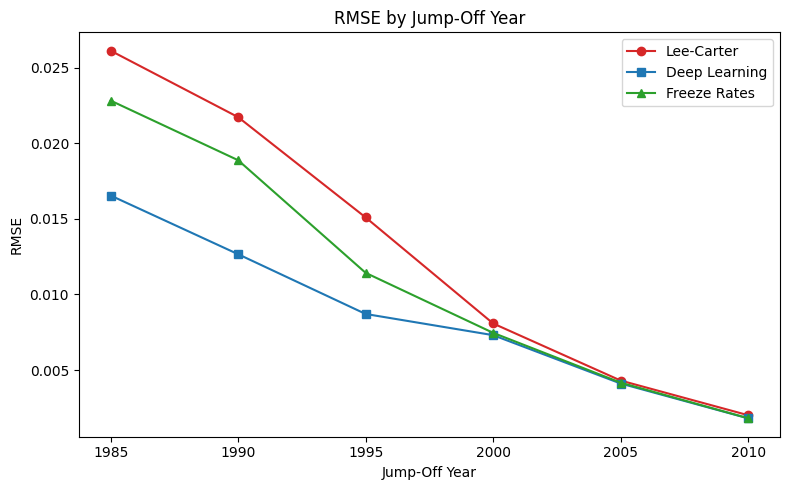

In [ ]:
# RMSE by Jump-Off Year: DL vs Lee-Carter
rmse_lee = df_merged_lee.groupby('JumpOffYear').apply(
    lambda g: np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean())
)
rmse_dl = df_merged_dl.groupby('JumpOffYear').apply(
    lambda g: np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean())
)

rmse_fr = df_merged_fr.groupby('JumpOffYear').apply(
    lambda g: np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean())
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rmse_lee.index, rmse_lee.values, 'o-', label='Lee-Carter', color='#d62728')
ax.plot(rmse_dl.index, rmse_dl.values, 's-', label='Deep Learning', color='#1f77b4')
ax.plot(rmse_fr.index, rmse_fr.values, '^-', label='Freeze Rates', color='#2ca02c') 
ax.set_xlabel('Jump-Off Year')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Jump-Off Year')
ax.legend()
ax.set_xticks(rmse_lee.index)
plt.tight_layout()
plt.show()

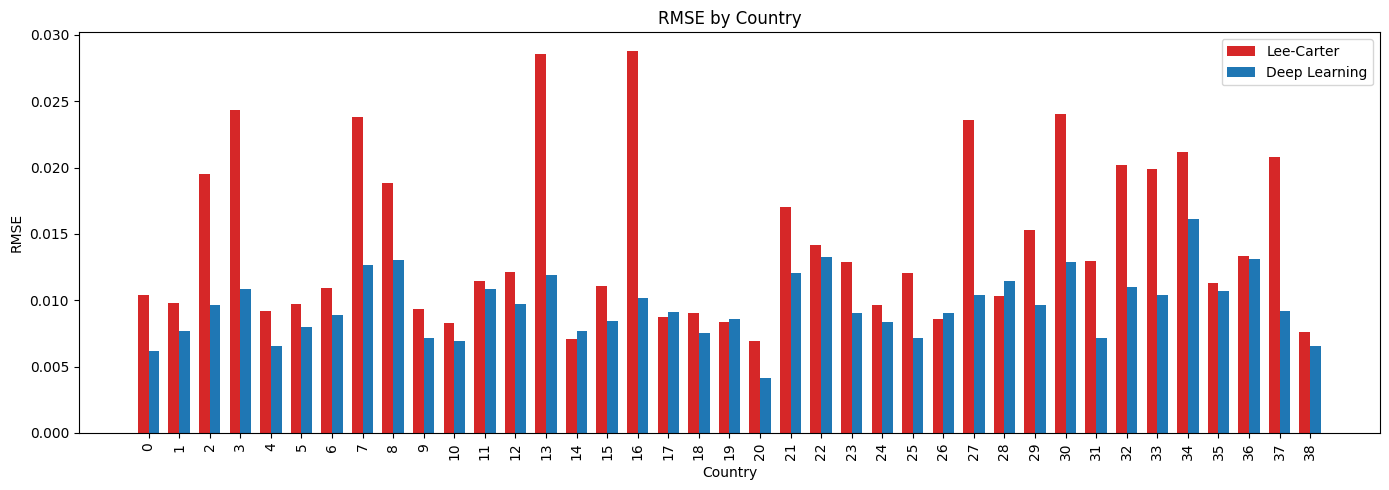

In [40]:
# RMSE by Country: DL vs Lee-Carter
rmse_lee_country = df_merged_lee.groupby('Country').apply(
    lambda g: np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean())
).sort_index()
rmse_dl_country = df_merged_dl.groupby('Country').apply(
    lambda g: np.sqrt(((g['Rate_pred'] - g['Rate_obs']) ** 2).mean())
).sort_index()

fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(len(rmse_lee_country))
width = 0.35
ax.bar(x - width/2, rmse_lee_country.values, width, label='Lee-Carter', color='#d62728')
ax.bar(x + width/2, rmse_dl_country.values, width, label='Deep Learning', color='#1f77b4')
ax.set_xlabel('Country')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Country')
ax.set_xticks(x)
ax.set_xticklabels(rmse_lee_country.index, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()